In [150]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
rc('font', **{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text',usetex=True)
from iminuit import Minuit
from pprint import pprint
from scipy.special import beta
from scipy.misc import derivative

# Load data

In [151]:
data = {}

dd = np.loadtxt('F1F2_pn.dat', skiprows = 4)
df = pd.DataFrame({'Q2': dd[:,0], 'F1p': dd[:,1], 'dF1p': dd[:,2], 'F2p': dd[:,3], 'dF2p': dd[:,4],\
                  'F1n': dd[:,5], 'dF1n': dd[:,6], 'F2n': dd[:,7], 'dF2n': dd[:,8]})
data['F1F2pn'] = pd.DataFrame(data=df)

dd = np.loadtxt('F1F2_ud.dat', skiprows = 5)
df = pd.DataFrame({'Q2': dd[:,0], 'F1u': dd[:,1], 'dF1u': dd[:,2], 'F1d': dd[:,3], 'dF1d': dd[:,4],\
                  'F2u': dd[:,5], 'dF2u': dd[:,6], 'F2d': dd[:,7], 'dF2d': dd[:,8]})
data['F1F2ud'] = pd.DataFrame(data=df)


# Funcitons

In [152]:
def G_D(Q2):
    return (1.0 + Q2/0.71)**(-2)

In [153]:
def alphat(t, kappa, a0):
    return t / (4.0 * kappa**2) + a0

In [154]:
class Parameters:    
    kappa = 0.533663
    a0rho = 0.492113
    a0omega = 0.5
    a0phi = 0.014219
    a0 = 0.5 - 0.1349770**2 / (4.0 * kappa**2)
    mup = 2.7928473446
    kap = mup - 1.0
    mun = -1.9130427
    kan = mun
    Mp = 0.938272081
    Mn = 0.939565413
    kau = 2.0 * kap + kan
    kad = kap + 2.0 * kan
    Mpi = 0.1349770
    normalweight = 1e6
    
    def __int__(self):
        pass
    
    def reset(self):
        self.kappa = Parameters.kappa
        self.a0 = Parameters.a0
    
    def sample(self):
        self.kappa = Parameters.kappa * np.random.normal(1.0, 0.05)
        self.a0 = 0.5 - Parameters.Mpi**2 / (4.0 * self.kappa**2)
    
    def setkappa(self, kappa):
        self.kappa = kappa
        self.a0 = 0.5 - Parameters.Mpi**2 / (4.0 * kappa**2)
        
        
    
Par = Parameters()

In [241]:
class Coef:
    u3 = 2.0
    u4 = 0.0
    u5 = 0.0
    u6 = 0.0
    d3 = 1.0
    d4 = 0.0
    d5 = 0.0
    d6 = 0.0
    
    def __init__(self):
        pass
    
    def setvalue(self, div):
        udiv = np.sort(div[:3])
        self.u3 = udiv[0]
        self.u4 = udiv[1] - udiv[0]
        self.u5 = udiv[2] - udiv[1]
        self.u6 = 2.0 - udiv[2]
        ddiv = np.sort(div[3:])
        self.d3 = ddiv[0]
        self.d4 = ddiv[1] - ddiv[0]
        self.d5 = ddiv[2] - ddiv[1]
        self.d6 = 1.0 - ddiv[2]
    
    def setcoef(self, coef):
        self.u3 = coef[0]
        self.u4 = coef[1]
        self.u5 = coef[2]
        self.u6 = coef[3]
        self.d3 = coef[4]
        self.d4 = coef[5]
        self.d5 = coef[6]
        self.d6 = coef[7]
        
    def Print(self):
        print 'u3 = ', '%.6e'%self.u3
        print 'u4 = ', '%.6e'%self.u4 
        print 'u5 = ', '%.6e'%self.u5 
        print 'u6 = ', '%.6e'%self.u6
        print 'd3 = ', '%.6e'%self.d3 
        print 'd4 = ', '%.6e'%self.d4 
        print 'd5 = ', '%.6e'%self.d5 
        print 'd6 = ', '%.6e'%self.d6
        
        
coef = Coef()

In [156]:
def FF(tau, Q2):
    return beta(tau - 1.0, 1.0 - alphat(-Q2, Par.kappa, Par.a0)) / beta(tau - 1.0, 1.0 - Par.a0)

def FFiv(tau, Q2):
    return beta(tau - 1.0, 1.0 - alphat(-Q2, Par.kappa, Par.a0rho)) / beta(tau - 1.0, 1.0 - Par.a0rho)

def FFis(tau, Q2):
    return beta(tau - 1.0, 1.0 - alphat(-Q2, Par.kappa, Par.a0omega)) / beta(tau - 1.0, 1.0 - Par.a0omega)

def FFs(tau, Q2):
    return beta(tau - 1.0, 1.0 - alphat(-Q2, Par.kappa, Par.a0phi)) / beta(tau - 1.0, 1.0 - Par.a0phi)

In [157]:
Par.reset()
print Par.kappa, Par.a0

0.533663 0.484007168385


# Fit: 

## Form factors

In [158]:
def F1u(Q2):
    return coef.u3 * FF(3, Q2) + coef.u4 * FF(4, Q2) + coef.u5 * FF(5, Q2) + coef.u6 * FF(6, Q2)

def F1d(Q2):
    return coef.d3 * FF(3, Q2) + coef.d4 * FF(4, Q2) + coef.d5 * FF(5, Q2) + coef.d6 * FF(6, Q2)

def F1p(Q2):
    return 2.0/3.0 * F1u(Q2) - 1.0/3.0 * F1d(Q2)

def F1n(Q2):
    return 2.0/3.0 * F1d(Q2) - 1.0/3.0 * F1u(Q2)

def F2u(Q2):    
    return Par.kau * (np.sqrt(coef.u3 * coef.u4) * FF(4, Q2) + np.sqrt(coef.u5 * coef.u6) * FF(6, Q2)) / (np.sqrt(coef.u5 * coef.u6) + np.sqrt(coef.u3 * coef.u4))

def F2d(Q2):    
    return Par.kad * (np.sqrt(coef.d3 * coef.d4) * FF(4, Q2) + np.sqrt(coef.d5 * coef.d6) * FF(6, Q2)) / (np.sqrt(coef.d5 * coef.d6) + np.sqrt(coef.d3 * coef.d4))

def F2p(Q2):
    return 2.0/3.0 * F2u(Q2) - 1.0/3.0 * F2d(Q2)

def F2n(Q2):
    return 2.0/3.0 * F2d(Q2) - 1.0/3.0 * F2u(Q2)

def GEp(Q2):
    return F1p(Q2) - Q2 / (4.0 * Par.Mp**2) * F2p(Q2)

def GMp(Q2):
    return F1p(Q2) + F2p(Q2)

def GEn(Q2):
    return F1n(Q2) - Q2 / (4.0 * Par.Mn**2) * F2n(Q2)

def GMn(Q2):
    return F1n(Q2) + F2n(Q2)


In [220]:
eth = 0.0
rweight = 0

def Chi2u(par):
    coef.setcoef(par)
    result = 0.0
    result += Par.normalweight*((coef.u3+coef.u4+coef.u5+coef.u6 - 2)**2)
    result += rweight * np.power(derivative(F1u, 0, dx=1e-6) + 5.099, 2)
    result += rweight * np.power(derivative(F2u, 0, dx=1e-6) + 3.362, 2)
    Data = data['F1F2ud']
    Q2 = Data['Q2']
    result += np.sum((F1u(Q2) - Data['F1u'])**2 / (Data['dF1u']**2 + (Data['F1u']*eth)**2))
    result += np.sum((F2u(Q2) - Data['F2u'])**2 / (Data['dF2u']**2 + (Data['F2u']*eth)**2))
    return result
  
def Chi2d(par):
    coef.setcoef(par)
    result = 0.0
    result += Par.normalweight*((coef.d3+coef.d4+coef.d5+coef.d6 - 1)**2)    
    result += rweight * np.power(derivative(F1d, 0, dx=1e-6) + 2.641, 2)
    result += rweight * np.power(derivative(F2d, 0, dx=1e-6) - 7.583, 2)
    Data = data['F1F2ud']
    Q2 = Data['Q2']
    result += np.sum((F1d(Q2) - Data['F1d'])**2 / (Data['dF1d']**2 + (Data['F1d']*eth)**2))
    result += np.sum((F2d(Q2) - Data['F2d'])**2 / (Data['dF2d']**2 + (Data['F2d']*eth)**2))
    return result

def Chi2N(par):
    coef.setcoef(par)
    result = 0.0
    result += Par.normalweight * ((coef.u3+coef.u4+coef.u5+coef.u6 - 2)**2)
    result += Par.normalweight * ((coef.d3+coef.d4+coef.d5+coef.d6 - 1)**2)
    Data = data['F1F2pn']
    Q2 = Data['Q2']
    result += np.sum((F1p(Q2) - Data['F1p'])**2 / (Data['dF1p']**2 + (Data['F1p']*eth)**2))
    result += np.sum((F1p(Q2) - Data['F1n'])**2 / (Data['dF1n']**2 + (Data['F1n']*eth)**2))
    result += np.sum((F2p(Q2) - Data['F2p'])**2 / (Data['dF2p']**2 + (Data['F2p']*eth)**2))
    result += np.sum((F2p(Q2) - Data['F2n'])**2 / (Data['dF2n']**2 + (Data['F2n']*eth)**2))
    return result

## Fit-u

In [231]:
Par.reset()
Minu = Minuit.from_array_func(Chi2u, start = (0.6, 0.6, 0.6, 0.6, 0, 0, 0, 0),\
                            name = ('u3', 'u4', 'u5', 'u6', 'd3', 'd4', 'd5', 'd6'),\
                            error = (0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001),\
                            errordef = 1,\
                            fix = (False, False, False, False, True, True, True, True),\
                            limit = ((0, 2), (0, 2), (0, 2), (0, 2), (0, 1), (0, 1), (0, 1), (0, 1)))

In [232]:
Par.reset()
Par.normalweight = 10000 / (data['F1F2ud']['dF1u'].min()**2)
Minu.print_level = 1
fmin, fpar = Minu.migrad(ncall=100000)
fmin, fpar = Minu.migrad(ncall=100000)
valu = Minu.np_values()
Par.setkappa(Parameters.kappa*1.05)
fmin, fpar = Minu.migrad(ncall=100000)
fmin, fpar = Minu.migrad(ncall=100000)
valu1 = Minu.np_values()
Par.setkappa(Parameters.kappa*0.95)
fmin, fpar = Minu.migrad(ncall=100000)
fmin, fpar = Minu.migrad(ncall=100000)
valu2 = Minu.np_values()

FCN = 588.221802378 
 TOTAL NCALL = 6051 
 NCALLS = 6051 
 
 
 EDM = 6.25873181174e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,u3,1.58758,0.000165665,,,0,2,No
1,u4,0.130629,0.000165694,,,0,2,No
2,u5,0.135148,0.0001657,,,0,2,No
3,u6,0.146644,0.000165693,,,0,2,No
4,d3,0,0.001,,,0,1,Yes
5,d4,0,0.001,,,0,1,Yes
6,d5,0,0.001,,,0,1,Yes
7,d6,0,0.001,,,0,1,Yes


FCN = 561.136966855 
 TOTAL NCALL = 15778 
 NCALLS = 9727 
 
 
 EDM = 6.18864743611e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,u3,1.66141,0.000188503,,,0,2,No
1,u4,1.06705e-05,2.03579e-05,,,0,2,No
2,u5,4.54129e-06,8.66357e-06,,,0,2,No
3,u6,0.338574,0.000188504,,,0,2,No
4,d3,0,0.001,,,0,1,Yes
5,d4,0,0.001,,,0,1,Yes
6,d5,0,0.001,,,0,1,Yes
7,d6,0,0.001,,,0,1,Yes


FCN = 930.132074686 
 TOTAL NCALL = 17115 
 NCALLS = 1337 
 
 
 EDM = 6.74708800794e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,u3,1.34235,0.000190842,,,0,2,No
1,u4,1.75576e-06,2.20718e-06,,,0,2,No
2,u5,3.42772e-06,4.30919e-06,,,0,2,No
3,u6,0.657646,0.000190844,,,0,2,No
4,d3,0,0.001,,,0,1,Yes
5,d4,0,0.001,,,0,1,Yes
6,d5,0,0.001,,,0,1,Yes
7,d6,0,0.001,,,0,1,Yes


FCN = 930.132067794 
 TOTAL NCALL = 17141 
 NCALLS = 26 
 
 
 EDM = 1.52673561284e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,u3,1.34235,0.000190841,,,0,2,No
1,u4,1.75496e-06,2.2542e-06,,,0,2,No
2,u5,3.42589e-06,4.41674e-06,,,0,2,No
3,u6,0.657646,0.00019082,,,0,2,No
4,d3,0,0.001,,,0,1,Yes
5,d4,0,0.001,,,0,1,Yes
6,d5,0,0.001,,,0,1,Yes
7,d6,0,0.001,,,0,1,Yes


FCN = 426.498865345 
 TOTAL NCALL = 20019 
 NCALLS = 2878 
 
 
 EDM = 3.32407424851e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,u3,2,2.74042e-05,,,0,2,No
1,u4,3.46196e-08,1.31685e-05,,,0,2,No
2,u5,5.41112e-12,0.00451253,,,0,2,No
3,u6,1.09912e-14,2.36739e-05,,,0,2,No
4,d3,0,0.001,,,0,1,Yes
5,d4,0,0.001,,,0,1,Yes
6,d5,0,0.001,,,0,1,Yes
7,d6,0,0.001,,,0,1,Yes


FCN = 426.500616462 
 TOTAL NCALL = 20168 
 NCALLS = 149 
 
 
 EDM = 2.15067190764e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,u3,2,0.000489274,,,0,2,No
1,u4,5.26322e-08,0.0695902,,,0,2,No
2,u5,0,8.39363e-09,,,0,2,No
3,u6,2.19175e-06,0.000712978,,,0,2,No
4,d3,0,0.001,,,0,1,Yes
5,d4,0,0.001,,,0,1,Yes
6,d5,0,0.001,,,0,1,Yes
7,d6,0,0.001,,,0,1,Yes


In [233]:
coef.setcoef(valu)
coef.Print()
print coef.u3 + coef.u4 + coef.u5 + coef.u6
coef.setcoef(valu1)
coef.Print()
print coef.u3 + coef.u4 + coef.u5 + coef.u6
coef.setcoef(valu2)
coef.Print()
print coef.u3 + coef.u4 + coef.u5 + coef.u6

u3 =  1.6614e+00
u4 =  1.0670e-05
u5 =  4.5413e-06
u6 =  3.3857e-01
d3 =  0.0000e+00
d4 =  0.0000e+00
d5 =  0.0000e+00
d6 =  0.0000e+00
1.9999998906718721
u3 =  1.3423e+00
u4 =  1.7550e-06
u5 =  3.4259e-06
u6 =  6.5765e-01
d3 =  0.0000e+00
d4 =  0.0000e+00
d5 =  0.0000e+00
d6 =  0.0000e+00
1.9999997495112913
u3 =  2.0000e+00
u4 =  5.2632e-08
u5 =  0.0000e+00
u6 =  2.1917e-06
d3 =  0.0000e+00
d4 =  0.0000e+00
d5 =  0.0000e+00
d6 =  0.0000e+00
2.0000000426600755


## Fit-d

In [234]:
Par.reset()
Mind = Minuit.from_array_func(Chi2d, start = (0, 0, 0, 0, 0.3, 0.3, 0.3, 0.3),\
                            name = ('u3', 'u4', 'u5', 'u6', 'd3', 'd4', 'd5', 'd6'),\
                            error = (0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001),\
                            errordef = 1,\
                            fix = (True, True, True, True, False, False, False, False),\
                            limit = ((0, 2), (0, 2), (0, 2), (0, 2), (0, 1), (0, 1), (0, 1), (0, 1)))

In [235]:
Par.reset()
Par.normalweight = 10000 / data['F1F2ud']['dF1d'].min()**2
Mind.print_level = 1
fmin, fpar = Mind.migrad(ncall=100000)
fmin, fpar = Mind.migrad(ncall=100000)
vald = Mind.np_values()
Par.setkappa(Parameters.kappa*1.05)
fmin, fpar = Mind.migrad(ncall=100000)
fmin, fpar = Mind.migrad(ncall=100000)
vald1 = Mind.np_values()
Par.setkappa(Parameters.kappa*0.95)
fmin, fpar = Mind.migrad(ncall=100000)
fmin, fpar = Mind.migrad(ncall=100000)
vald2 = Mind.np_values()

FCN = 97.8109956907 
 TOTAL NCALL = 9789 
 NCALLS = 9789 
 
 
 EDM = 0.000108833200495 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,u3,0,0.001,,,0,2,Yes
1,u4,0,0.001,,,0,2,Yes
2,u5,0,0.001,,,0,2,Yes
3,u6,0,0.001,,,0,2,Yes
4,d3,9.00432e-05,0.000162946,,,0,1,No
5,d4,0.535482,0.000305789,,,0,1,No
6,d5,1.39941e-05,2.53531e-05,,,0,1,No
7,d6,0.464414,0.00030573,,,0,1,No


FCN = 97.8109836744 
 TOTAL NCALL = 9852 
 NCALLS = 63 
 
 
 EDM = 9.35324687382e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,u3,0,0.001,,,0,2,Yes
1,u4,0,0.001,,,0,2,Yes
2,u5,0,0.001,,,0,2,Yes
3,u6,0,0.001,,,0,2,Yes
4,d3,9.00261e-05,0.00015726,,,0,1,No
5,d4,0.535482,0.000311588,,,0,1,No
6,d5,1.39855e-05,2.4448e-05,,,0,1,No
7,d6,0.464414,0.000311537,,,0,1,No


FCN = 57.8193724861 
 TOTAL NCALL = 10584 
 NCALLS = 732 
 
 
 EDM = 7.7055289981e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,u3,0,0.001,,,0,2,Yes
1,u4,0,0.001,,,0,2,Yes
2,u5,0,0.001,,,0,2,Yes
3,u6,0,0.001,,,0,2,Yes
4,d3,0.000246179,0.000203551,,,0,1,No
5,d4,0.215731,0.000313685,,,0,1,No
6,d5,0.000125333,0.000103846,,,0,1,No
7,d6,0.783898,0.000313619,,,0,1,No


FCN = 57.8193724861 
 TOTAL NCALL = 10608 
 NCALLS = 24 
 
 
 EDM = 2.60674102751e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,u3,0,0.001,,,0,2,Yes
1,u4,0,0.001,,,0,2,Yes
2,u5,0,0.001,,,0,2,Yes
3,u6,0,0.001,,,0,2,Yes
4,d3,0.000246179,0.000203551,,,0,1,No
5,d4,0.215731,0.000313685,,,0,1,No
6,d5,0.000125333,0.000103846,,,0,1,No
7,d6,0.783898,0.000313619,,,0,1,No


FCN = 199.763808328 
 TOTAL NCALL = 18433 
 NCALLS = 7825 
 
 
 EDM = 0.00017878562238 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,u3,0,0.001,,,0,2,Yes
1,u4,0,0.001,,,0,2,Yes
2,u5,0,0.001,,,0,2,Yes
3,u6,0,0.001,,,0,2,Yes
4,d3,7.31288e-05,0.000283523,,,0,1,No
5,d4,0.895263,0.0234,,,0,1,No
6,d5,0,2.06608e-11,,,0,1,No
7,d6,0.104664,0.0233594,,,0,1,No


FCN = 199.752299168 
 TOTAL NCALL = 20782 
 NCALLS = 2338 
 
 
 EDM = 0.0312638589873 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,u3,0,0.001,,,0,2,Yes
1,u4,0,0.001,,,0,2,Yes
2,u5,0,0.001,,,0,2,Yes
3,u6,0,0.001,,,0,2,Yes
4,d3,1.14862e-05,0.00208769,,,0,1,No
5,d4,0.89503,0.000309131,,,0,1,No
6,d5,0,1.14201e-11,,,0,1,No
7,d6,0.104959,0.000309083,,,0,1,No


In [236]:
coef.setcoef(vald)
coef.Print()
print coef.d3 + coef.d4 + coef.d5 + coef.d6
coef.setcoef(vald1)
coef.Print()
print coef.d3 + coef.d4 + coef.d5 + coef.d6
coef.setcoef(vald2)
coef.Print()
print coef.d3 + coef.d4 + coef.d5 + coef.d6

u3 =  0.0000e+00
u4 =  0.0000e+00
u5 =  0.0000e+00
u6 =  0.0000e+00
d3 =  9.0026e-05
d4 =  5.3548e-01
d5 =  1.3985e-05
d6 =  4.6441e-01
1.0000001121165683
u3 =  0.0000e+00
u4 =  0.0000e+00
u5 =  0.0000e+00
u6 =  0.0000e+00
d3 =  2.4618e-04
d4 =  2.1573e-01
d5 =  1.2533e-04
d6 =  7.8390e-01
1.0000000083977665
u3 =  0.0000e+00
u4 =  0.0000e+00
u5 =  0.0000e+00
u6 =  0.0000e+00
d3 =  1.1486e-05
d4 =  8.9503e-01
d5 =  0.0000e+00
d6 =  1.0496e-01
1.000000398447886


## Fit-N

In [197]:
Par.reset()
MinN = Minuit.from_array_func(Chi2N, start = (0.6, 0.6, 0.6, 0.6, 0.3, 0.3, 0.3, 0.3),\
                            name = ('u3', 'u4', 'u5', 'u6', 'd3', 'd4', 'd5', 'd6'),\
                            error = (0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001),\
                            errordef = 1,\
                            fix = (False, False, False, False, False, False, False, False),\
                            limit = ((0, 2), (0, 2), (0, 2), (0, 2), (0, 1), (0, 1), (0, 1), (0, 1)))

In [202]:
Par.reset()
Par.normalweight = 1 / data['F1F2pn']['dF1p'].min()**2
MinN.print_level = 1
fmin, fpar = MinN.migrad(ncall=100000)
#fmin, fpar = MinN.migrad(ncall=100000)
valN = MinN.np_values()


FCN = 1158118.65098 
 TOTAL NCALL = 3767 
 NCALLS = 60 
 
 
 EDM = 1.12451061955e+12 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,u3,1.1135,1.44411,,,0,2,No
1,u4,1.90735e-06,1.22903,,,0,2,No
2,u5,0.000959244,1.2112,,,0,2,No
3,u6,0.881256,1.39047,,,0,2,No
4,d3,9.53674e-07,0.614514,,,0,1,No
5,d4,0.770911,0.739082,,,0,1,No
6,d5,0.23144,0.615718,,,0,1,No
7,d6,1.31533e-05,0.6134,,,0,1,No


In [200]:
coef.setcoef(valN)
coef.Print()
print coef.u3 + coef.u4 + coef.u5 + coef.u6
print coef.d3 + coef.d4 + coef.d5 + coef.d6

u3 =  1.1135e+00
u4 =  1.6764e-14
u5 =  9.5924e-04
u6 =  8.8126e-01
d3 =  5.5511e-17
d4 =  7.7091e-01
d5 =  2.3144e-01
d6 =  1.3153e-05
1.9957161612099257
1.0023643844775354


## Compare

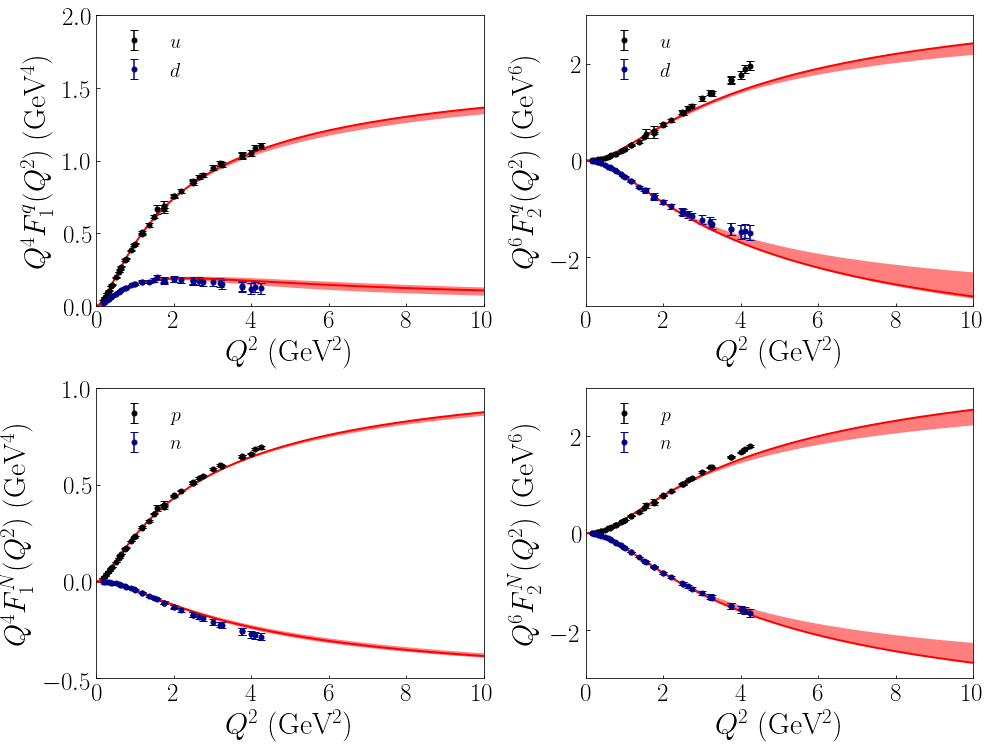

In [239]:
nrows, ncols = 2, 2

Q2 = np.linspace(0, 40, 5000)

Par.reset()
coef.setcoef(valu + vald)
q4f1u = Q2**2 * F1u(Q2)
q4f1d = Q2**2 * F1d(Q2)
q6f2u = Q2**3 * F2u(Q2)
q6f2d = Q2**3 * F2d(Q2)
q4f1p = Q2**2 * F1p(Q2)
q4f1n = Q2**2 * F1n(Q2)
q6f2p = Q2**3 * F2p(Q2)
q6f2n = Q2**3 * F2n(Q2)
Par.setkappa(Parameters.kappa*1.05)
coef.setcoef(valu1 + vald1)
q4f1uA = Q2**2 * F1u(Q2)
q4f1dA = Q2**2 * F1d(Q2)
q6f2uA = Q2**3 * F2u(Q2)
q6f2dA = Q2**3 * F2d(Q2)
q4f1pA = Q2**2 * F1p(Q2)
q4f1nA = Q2**2 * F1n(Q2)
q6f2pA = Q2**3 * F2p(Q2)
q6f2nA = Q2**3 * F2n(Q2)
Par.setkappa(Parameters.kappa*0.95)
coef.setcoef(valu2 + vald2)
q4f1uB = Q2**2 * F1u(Q2)
q4f1dB = Q2**2 * F1d(Q2)
q6f2uB = Q2**3 * F2u(Q2)
q6f2dB = Q2**3 * F2d(Q2)
q4f1pB = Q2**2 * F1p(Q2)
q4f1nB = Q2**2 * F1n(Q2)
q6f2pB = Q2**3 * F2p(Q2)
q6f2nB = Q2**3 * F2n(Q2)

fig = plt.figure(figsize=(ncols*7, nrows*7*0.75))



ax = fig.add_subplot(nrows, ncols, 1)
ax.errorbar(data['F1F2ud']['Q2'], data['F1F2ud']['Q2']**2 * data['F1F2ud']['F1u'],\
            yerr=data['F1F2ud']['Q2']**2 * data['F1F2ud']['dF1u'],\
            linestyle = '', marker = 'o', markersize = 5, capsize = 4, color = 'black', label=r'$u$')
ax.errorbar(data['F1F2ud']['Q2'], data['F1F2ud']['Q2']**2 * data['F1F2ud']['F1d'],\
            yerr=data['F1F2ud']['Q2']**2 * data['F1F2ud']['dF1d'],\
            linestyle = '', marker = 'o', markersize = 5, capsize = 4, color = 'darkblue', label=r'$d$')
ax.fill_between(Q2, np.min(np.array([q4f1u, q4f1uA, q4f1uB]), axis=0), np.max(np.array([q4f1u, q4f1uA, q4f1uB]), axis=0),\
               linewidth = 0, color = 'red', alpha = 0.5)
ax.fill_between(Q2, np.min(np.array([q4f1d, q4f1dA, q4f1dB]), axis=0), np.max(np.array([q4f1d, q4f1dA, q4f1dB]), axis=0),\
               linewidth = 0, color = 'red', alpha = 0.5)
ax.plot(Q2, q4f1u, linestyle = '-', linewidth=2, color = 'red')
ax.plot(Q2, q4f1d, linestyle = '-', linewidth=2, color = 'red')
ax.set_xlim(0, 10)
ax.set_ylim(0, 2)
ax.set_xlabel(r'$Q^2~\rm (GeV^2)$', size=30)
ax.set_ylabel(r'$Q^4F_1^q(Q^2)~\rm (GeV^4)$', size = 30)
ax.tick_params(axis = 'both', which = 'both', direction = 'in', labelsize = 25)
ax.legend(frameon = False, fontsize = 20, loc = 'upper left')

ax = fig.add_subplot(nrows, ncols, 2)
ax.errorbar(data['F1F2ud']['Q2'], data['F1F2ud']['Q2']**3 * data['F1F2ud']['F2u'],\
            yerr=data['F1F2ud']['Q2']**3 * data['F1F2ud']['dF2u'],\
            linestyle = '', marker = 'o', markersize = 5, capsize = 4, color = 'black', label=r'$u$')
ax.errorbar(data['F1F2ud']['Q2'], data['F1F2ud']['Q2']**3 * data['F1F2ud']['F2d'],\
            yerr=data['F1F2ud']['Q2']**3 * data['F1F2ud']['dF2d'],\
            linestyle = '', marker = 'o', markersize = 5, capsize = 4, color = 'darkblue', label=r'$d$')
ax.fill_between(Q2, np.min(np.array([q6f2u, q6f2uA, q6f2uB]), axis=0), np.max(np.array([q6f2u, q6f2uA, q6f2uB]), axis=0),\
               linewidth = 0, color = 'red', alpha = 0.5)
ax.fill_between(Q2, np.min(np.array([q6f2d, q6f2dA, q6f2dB]), axis=0), np.max(np.array([q6f2d, q6f2dA, q6f2dB]), axis=0),\
               linewidth = 0, color = 'red', alpha = 0.5)
ax.plot(Q2, q6f2u, linestyle = '-', linewidth=2, color = 'red')
ax.plot(Q2, q6f2d, linestyle = '-', linewidth=2, color = 'red')
ax.set_xlim(0, 10)
ax.set_ylim(-3, 3)
ax.set_xlabel(r'$Q^2~\rm (GeV^2)$', size=30)
ax.set_ylabel(r'$Q^6F_2^q(Q^2)~\rm (GeV^6)$', size = 30)
ax.tick_params(axis = 'both', which = 'both', direction = 'in', labelsize = 25)
ax.legend(frameon = False, fontsize = 20, loc = 'upper left')

ax = fig.add_subplot(nrows, ncols, 3)
ax.errorbar(data['F1F2pn']['Q2'], data['F1F2pn']['Q2']**2 * data['F1F2pn']['F1p'],\
            yerr=data['F1F2pn']['Q2']**2 * data['F1F2pn']['dF1p'],\
            linestyle = '', marker = 'o', markersize = 5, capsize = 4, color = 'black', label=r'$p$')
ax.errorbar(data['F1F2pn']['Q2'], data['F1F2pn']['Q2']**2 * data['F1F2pn']['F1n'],\
            yerr=data['F1F2pn']['Q2']**2 * data['F1F2pn']['dF1n'],\
            linestyle = '', marker = 'o', markersize = 5, capsize = 4, color = 'darkblue', label=r'$n$')
ax.fill_between(Q2, np.min(np.array([q4f1p, q4f1pA, q4f1pB]), axis=0), np.max(np.array([q4f1p, q4f1pA, q4f1pB]), axis=0),\
               linewidth = 0, color = 'red', alpha = 0.5)
ax.fill_between(Q2, np.min(np.array([q4f1n, q4f1nA, q4f1nB]), axis=0), np.max(np.array([q4f1n, q4f1nA, q4f1nB]), axis=0),\
               linewidth = 0, color = 'red', alpha = 0.5)
ax.plot(Q2, q4f1p, linestyle = '-', linewidth=2, color = 'red')
ax.plot(Q2, q4f1n, linestyle = '-', linewidth=2, color = 'red')
ax.set_xlim(0, 10)
ax.set_ylim(-0.5, 1)
ax.set_xlabel(r'$Q^2~\rm (GeV^2)$', size=30)
ax.set_ylabel(r'$Q^4F_1^N(Q^2)~\rm (GeV^4)$', size = 30)
ax.tick_params(axis = 'both', which = 'both', direction = 'in', labelsize = 25)
ax.legend(frameon = False, fontsize = 20, loc = 'upper left')

ax = fig.add_subplot(nrows, ncols, 4)
ax.errorbar(data['F1F2pn']['Q2'], data['F1F2pn']['Q2']**3 * data['F1F2pn']['F2p'],\
            yerr=data['F1F2pn']['Q2']**3 * data['F1F2pn']['dF2p'],\
            linestyle = '', marker = 'o', markersize = 5, capsize = 4, color = 'black', label=r'$p$')
ax.errorbar(data['F1F2pn']['Q2'], data['F1F2pn']['Q2']**3 * data['F1F2pn']['F2n'],\
            yerr=data['F1F2pn']['Q2']**3 * data['F1F2pn']['dF2n'],\
            linestyle = '', marker = 'o', markersize = 5, capsize = 4, color = 'darkblue', label=r'$n$')
ax.fill_between(Q2, np.min(np.array([q6f2p, q6f2pA, q6f2pB]), axis=0), np.max(np.array([q6f2p, q6f2pA, q6f2pB]), axis=0),\
               linewidth = 0, color = 'red', alpha = 0.5)
ax.fill_between(Q2, np.min(np.array([q6f2n, q6f2nA, q6f2nB]), axis=0), np.max(np.array([q6f2n, q6f2nA, q6f2nB]), axis=0),\
               linewidth = 0, color = 'red', alpha = 0.5)
ax.plot(Q2, q6f2p, linestyle = '-', linewidth=2, color = 'red')
ax.plot(Q2, q6f2n, linestyle = '-', linewidth=2, color = 'red')
ax.set_xlim(0, 10)
ax.set_ylim(-3, 3)
ax.set_xlabel(r'$Q^2~\rm (GeV^2)$', size=30)
ax.set_ylabel(r'$Q^6F_2^N(Q^2)~\rm (GeV^6)$', size = 30)
ax.tick_params(axis = 'both', which = 'both', direction = 'in', labelsize = 25)
ax.legend(frameon = False, fontsize = 20, loc = 'upper left')

fig.tight_layout()
fig.savefig('plots/F1F2.pdf')

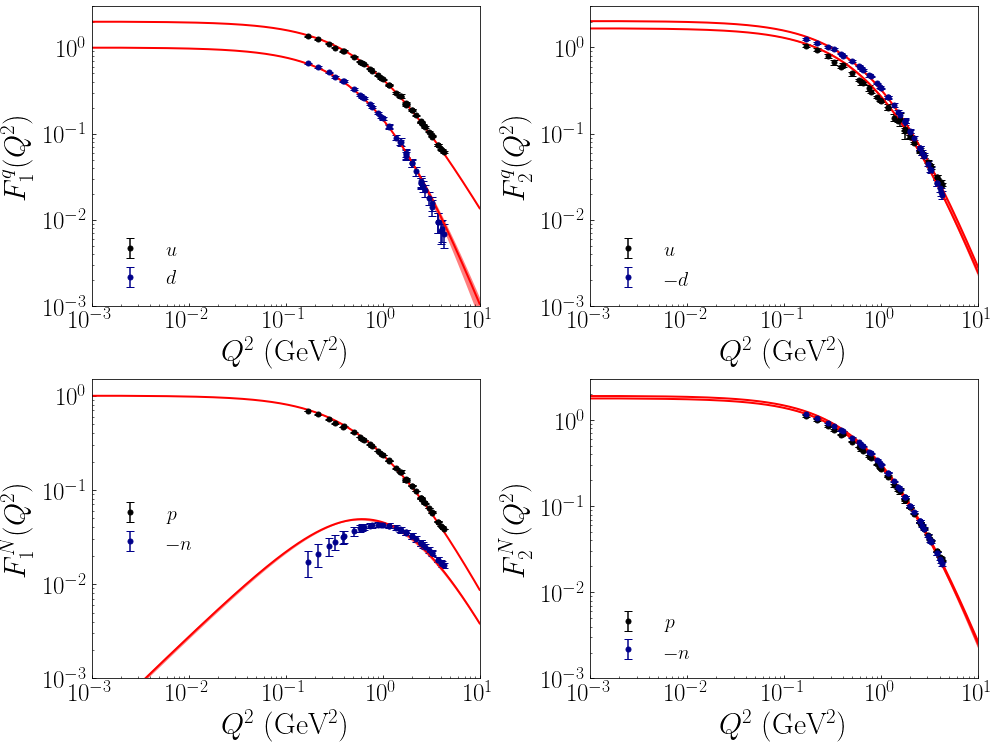

In [238]:
nrows, ncols = 2, 2

Q2 = np.linspace(0, 40, 20000)
f1s = 0.046 * (FFs(5, Q2) - FFs(6, Q2))

Par.reset()
coef.setcoef(valu + vald)
f1u = F1u(Q2)
f1d = F1d(Q2)
f2u = F2u(Q2)
f2d = F2d(Q2)
f1p = F1p(Q2) - f1s/3
f1n = F1n(Q2) - f1s/3
f2p = F2p(Q2)
f2n = F2n(Q2)
Par.setkappa(Parameters.kappa*1.05)
coef.setcoef(valu1 + vald1)
f1uA = F1u(Q2)
f1dA = F1d(Q2)
f2uA = F2u(Q2)
f2dA = F2d(Q2)
f1pA = F1p(Q2)
f1nA = F1n(Q2)
f2pA = F2p(Q2)
f2nA = F2n(Q2)
Par.setkappa(Parameters.kappa*0.95)
coef.setcoef(valu2 + vald2)
f1uB = F1u(Q2)
f1dB = F1d(Q2)
f2uB = F2u(Q2)
f2dB = F2d(Q2)
f1pB = F1p(Q2)
f1nB = F1n(Q2)
f2pB = F2p(Q2)
f2nB = F2n(Q2)

fig = plt.figure(figsize=(ncols*7, nrows*7*0.75))



ax = fig.add_subplot(nrows, ncols, 1)
ax.errorbar(data['F1F2ud']['Q2'], data['F1F2ud']['F1u'], yerr=data['F1F2ud']['dF1u'],\
            linestyle = '', marker = 'o', markersize = 5, capsize = 4, color = 'black', label=r'$u$')
ax.errorbar(data['F1F2ud']['Q2'], data['F1F2ud']['F1d'], yerr=data['F1F2ud']['dF1d'],\
            linestyle = '', marker = 'o', markersize = 5, capsize = 4, color = 'darkblue', label=r'$d$')
ax.fill_between(Q2, np.min(np.array([f1u, f1uA, f1uB]), axis=0), np.max(np.array([f1u, f1uA, f1uB]), axis=0),\
               linewidth = 0, color = 'red', alpha = 0.5)
ax.fill_between(Q2, np.min(np.array([f1d, f1dA, f1dB]), axis=0), np.max(np.array([f1d, f1dA, f1dB]), axis=0),\
               linewidth = 0, color = 'red', alpha = 0.5)
ax.plot(Q2, f1u, linestyle = '-', linewidth=2, color = 'red')
ax.plot(Q2, f1d, linestyle = '-', linewidth=2, color = 'red')
ax.set_xlim(1e-3, 10)
ax.set_ylim(1e-3, 3)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$Q^2~\rm (GeV^2)$', size=30)
ax.set_ylabel(r'$F_1^q(Q^2)$', size = 30)
ax.tick_params(axis = 'both', which = 'both', direction = 'in', labelsize = 25)
ax.legend(frameon = False, fontsize = 20, loc = 'lower left')

ax = fig.add_subplot(nrows, ncols, 2)
ax.errorbar(data['F1F2ud']['Q2'], data['F1F2ud']['F2u'], yerr=data['F1F2ud']['dF2u'],\
            linestyle = '', marker = 'o', markersize = 5, capsize = 4, color = 'black', label=r'$u$')
ax.errorbar(data['F1F2ud']['Q2'], -data['F1F2ud']['F2d'], yerr=data['F1F2ud']['dF2d'],\
            linestyle = '', marker = 'o', markersize = 5, capsize = 4, color = 'darkblue', label=r'$-d$')
ax.fill_between(Q2, np.min(np.array([f2u, f2uA, f2uB]), axis=0),\
                np.max(np.array([f2u, f2uA, f2uB]), axis=0),\
               linewidth = 0, color = 'red', alpha = 0.5)
ax.fill_between(Q2, -np.min(np.array([f2d, f2dA, f2dB]), axis=0),\
                -np.max(np.array([f2d, f2dA, f2dB]), axis=0),\
               linewidth = 0, color = 'red', alpha = 0.5)
ax.plot(Q2, f2u, linestyle = '-', linewidth=2, color = 'red')
ax.plot(Q2, -f2d, linestyle = '-', linewidth=2, color = 'red')
ax.set_xlim(1e-3, 10)
ax.set_ylim(1e-3, 3)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$Q^2~\rm (GeV^2)$', size=30)
ax.set_ylabel(r'$F_2^q(Q^2)$', size = 30)
ax.tick_params(axis = 'both', which = 'both', direction = 'in', labelsize = 25)
ax.legend(frameon = False, fontsize = 20, loc = 'lower left')

ax = fig.add_subplot(nrows, ncols, 3)
ax.errorbar(data['F1F2pn']['Q2'], data['F1F2pn']['F1p'], yerr=data['F1F2pn']['dF1p'],\
            linestyle = '', marker = 'o', markersize = 5, capsize = 4, color = 'black', label=r'$p$')
ax.errorbar(data['F1F2pn']['Q2'], -data['F1F2pn']['F1n'], yerr=data['F1F2pn']['dF1n'],\
            linestyle = '', marker = 'o', markersize = 5, capsize = 4, color = 'darkblue', label=r'$-n$')
ax.fill_between(Q2, np.min(np.array([f1p, f1pA, f1pB]), axis=0), np.max(np.array([f1p, f1pA, f1pB]), axis=0),\
               linewidth = 0, color = 'red', alpha = 0.5)
ax.fill_between(Q2, -np.min(np.array([f1n, f1nA, f1nB]), axis=0), -np.max(np.array([f1n, f1nA, f1nB]), axis=0),\
               linewidth = 0, color = 'red', alpha = 0.5)
ax.plot(Q2, f1p, linestyle = '-', linewidth=2, color = 'red')
ax.plot(Q2, -f1n, linestyle = '-', linewidth=2, color = 'red')
ax.set_xlim(1e-3, 10)
ax.set_ylim(1e-3, 1.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$Q^2~\rm (GeV^2)$', size=30)
ax.set_ylabel(r'$F_1^N(Q^2)$', size = 30)
ax.tick_params(axis = 'both', which = 'both', direction = 'in', labelsize = 25)
ax.legend(frameon = False, fontsize = 20, loc = 'center left')

ax = fig.add_subplot(nrows, ncols, 4)
ax.errorbar(data['F1F2pn']['Q2'], data['F1F2pn']['F2p'], yerr=data['F1F2pn']['dF2p'],\
            linestyle = '', marker = 'o', markersize = 5, capsize = 4, color = 'black', label=r'$p$')
ax.errorbar(data['F1F2pn']['Q2'], -data['F1F2pn']['F2n'], yerr=data['F1F2pn']['dF2n'],\
            linestyle = '', marker = 'o', markersize = 5, capsize = 4, color = 'darkblue', label=r'$-n$')
ax.fill_between(Q2, np.min(np.array([f2p, f2pA, f2pB]), axis=0), np.max(np.array([f2p, f2pA, f2pB]), axis=0),\
               linewidth = 0, color = 'red', alpha = 0.5)
ax.fill_between(Q2, -np.min(np.array([f2n, f2nA, f2nB]), axis=0), -np.max(np.array([f2n, f2nA, f2nB]), axis=0),\
               linewidth = 0, color = 'red', alpha = 0.5)
ax.plot(Q2, f2p, linestyle = '-', linewidth=2, color = 'red')
ax.plot(Q2, -f2n, linestyle = '-', linewidth=2, color = 'red')
ax.set_xlim(1e-3, 10)
ax.set_ylim(1e-3, 3)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$Q^2~\rm (GeV^2)$', size=30)
ax.set_ylabel(r'$F_2^N(Q^2)$', size = 30)
ax.tick_params(axis = 'both', which = 'both', direction = 'in', labelsize = 25)
ax.legend(frameon = False, fontsize = 20, loc = 'lower left')

fig.tight_layout()
fig.savefig('plots/F1F2loglog.pdf')

In [242]:
coef.setcoef(valu + vald)
coef.Print()

u3 =  1.661411e+00
u4 =  1.067049e-05
u5 =  4.541289e-06
u6 =  3.385740e-01
d3 =  9.002607e-05
d4 =  5.354819e-01
d5 =  1.398545e-05
d6 =  4.644142e-01


In [217]:
coef.setcoef(valu1 + vald1)
coef.Print()

u3 =  1.3440e+00
u4 =  1.2444e-07
u5 =  2.4482e-07
u6 =  6.5353e-01
d3 =  1.8148e-07
d4 =  2.1617e-01
d5 =  9.2584e-08
d6 =  7.8390e-01


In [218]:
coef.setcoef(valu2 + vald2)
coef.Print()

u3 =  2.0000e+00
u4 =  5.7133e-05
u5 =  2.9976e-14
u6 =  4.4980e-12
d3 =  3.2015e-12
d4 =  8.9149e-01
d5 =  0.0000e+00
d6 =  1.1035e-01


In [178]:
Par.setkappa(Parameters.kappa * 1.05)
Par.kappa, Par.a0

(0.56034615, 0.4854940302813807)

In [179]:
Par.setkappa(Parameters.kappa * 0.95)
Par.kappa, Par.a0

(0.50697985, 0.4822794109531548)

In [180]:
Par.setkappa(Parameters.kappa )
Par.kappa, Par.a0

(0.533663, 0.48400716838522223)

In [182]:
df = pd.DataFrame(data = {'Q2': Q2, 'q4f1u': q4f1u, 'q4f1uA': q4f1uA, 'q4f1uB': q4f1uB,\
                         'q4f1d': q4f1d, 'q4f1dA': q4f1dA, 'q4f1dB': q4f1dB,\
                         'q6f2u': q6f2u, 'q6f2uA': q6f2uA, 'q6f2uB': q6f2uB,\
                         'q6f2d': q6f2d, 'q6f2dA': q6f2dA, 'q6f2dB': q6f2dB,})

In [189]:
df.to_csv('plots/F1F2.csv', index=False, sep = ',')